
# Model of "Colonnade: A Reconfigurable SRAM-Based Digital Bit-Serial
Compute-In-Memory Macro for Processing Neural Networks ", JSSC 2021
--------------------------------------------------------------------------------

Paper by Hyunjoon Kim, Taegeun Yoo, Tony Tae-Hyoung Kim, and Bongjin Kim

## Description of The Macro

Colonnade is an SRAM-based digital CiM macro that supports variable-precision
(1-16b) inputs and weights. Its fully-digital implementation allows it to
compute MAC operations with full precision (*i.e.,* no quantization error and no
loss of fidelity). The macro uses a 128-row by 128-column SRAM array.

Note that our model and language here are different than that of the paper. In
the paper, outputs are reused between columns and inputs are reused between
rows. For consistency with the other models, we have chosen to transpose the
array such that outputs are reused between rows and inputs are reused between
columns. **In the language below, we will refer to the array as if it were
transposed in order to match our models. For a true representation of the
paper's fabricated chip, swap rows for columns and vice versa.**

To support in-array digital computation, every SRAM bitcell is augmented with a
MUX (to reconfigure), XNOR gate (to perform a 1b multiply), and a full adder (to
accumulate). The macro is pipelined to increase throughput; every eight array
rows are separated by registers (flip flops) such that the critical path length
only traverses the full adders of eight rows.

To support variable-precision inputs, each input bit is processed in a separate
cycle. To support variable-precision weights, weights may be stored in 1-16
columns, one column for each weight bit. An additional log2(#rows) bits are
needed for each weight (7 with the 128-row array) because the result of #rows
MAC operations are accumulated in the array, and accumulated outputs may be up
to 7 bits larger by the time they reach the last row of the array.

Some of the important variables for colonnade_jssc_2021:

- *ARRAY_WORDLINES*: 128 rows in the array
- *ARRAY_BITLINES*: 128 columns in the array
- *ARRAY_PARALLEL_INPUTS*: 128 input slice(s) consumed in each cycle.
- *ARRAY_PARALLEL_WEIGHTS*: 16384 weights slice(s) used for computation in each cycle.
- *ARRAY_PARALLEL_OUTPUTS*: 128 output(s) produced in each cycle.
- *TECHNOLOGY*: 65 nm
- *ADC_RESOLUTION*: 1 bit(s)
- *DAC_RESOLUTION*: 1 bit(s)
- *N_ADC_PER_BANK*: None ADC(s)
- *SUPPORTED_INPUT_BITS*: 16 bit(s)
- *SUPPORTED_OUTPUT_BITS*: 24 bit(s)
- *SUPPORTED_WEIGHT_BITS*: 16 bit(s)
- *BITS_PER_CELL*: 1 bit(s)
- *CIM_UNIT_WIDTH_CELLS*: 1 adjacent cell(s) in a wordline store bit(s) in one weight slice and process one input & output slice together
- *CIM_UNIT_DEPTH_CELLS*: 1 adjacent cell(s) in a bitline operate in separate cycles
- *CELL_CONFIG*: None 
- *GLOBAL_CYCLE_SECONDS*: 7.2e-09 clock period

### Macro Level

- *Input Path*: Row drivers supply one input bit at a time to the array. Inputs
  are provided to the input ports of the array's digital logic. We charge for
  the per-cell digital logic here because one input will be sent to ALL cells in
  a row (because they are wired together) regardless of whether the cell is used
  for a computation or not.
- *Weight Path*: Weight drivers are used to rewrite weights in the array.
- *Output Path*: Column drivers activate columns for reading.

Next, there are 128 columns. Each column stores either a vector of weight bits
or is set to zero to allow for MAC results to spill over into that column.
Inputs are reused between columns (*i.e.,* each input-carrying wire connects to
all columns), while outputs and weights are not reused.

### Column Level

- *Input Path*: Each input is passed directly to a row group in the column.
- *Weight Path*: A column bandwidth limiter sets the read and write bandwidth of
  each array column. Each weight is then passed to a row group in the column.
- *Output Path*: Outputs also pass through a column bandwidth limiter to set the
  read and write bandwidth of each array column.
  
Next, there are 16 row groups in the column. Each row group contains 8 rows of
SRAM cells. Outputs are reused between row groups (*i.e.,* the output of one row
group is propagated to the next for further accumulation), while inputs and
weights are not reused.

### Row Group Level

- *Input Path*: Each input is passed directly to a row in the row group.
- *Weight Path*: Each weight is passed directly to a row in the row group.
- *Output Path*: Outputs pass through a register. A register, in the form of a
  flip-flop for each column of the array, reduces the critical path length of
  the array and to allow for a faster pipelined operation.
  
Next, there are 8 rows in each row group. Outputs are reused between rows
(*i.e.,* are propagated from the full adders of one row to the next), while
inputs and weights are not reused.

### Row Level

- *Input Path*: The input is used for a MAC operation.
- *Weight Path*: A 1b weight is stored in the one SRAM cell in the CiM unit in
  the row. Additional digital logic multiplies the input & weight, computes 1b
  MAC operations, and accumulates outputs from adjacent rows and columns.
- *Output Path*: The output is used for a MAC operation.

Inside the CiM unit, one or more virtualized MAC units compute the MAC
operation. Note that the number of virtualized MAC units may change depending on
the number of bits of input and weight that are being used.


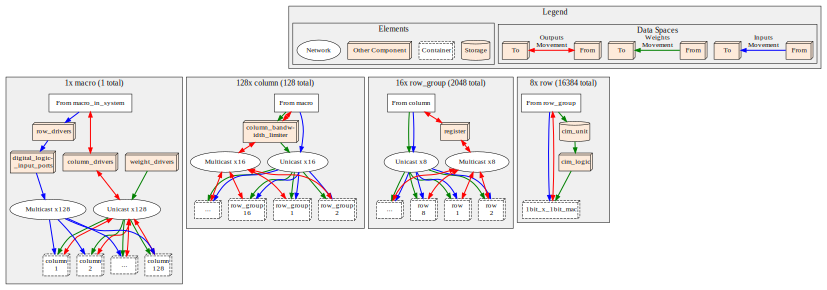

In [1]:
from _tests import scripts
from scripts.notebook_utils import *

display_markdown(
    f"""
# Model of "Colonnade: A Reconfigurable SRAM-Based Digital Bit-Serial
Compute-In-Memory Macro for Processing Neural Networks ", JSSC 2021
--------------------------------------------------------------------------------

Paper by Hyunjoon Kim, Taegeun Yoo, Tony Tae-Hyoung Kim, and Bongjin Kim

## Description of The Macro

Colonnade is an SRAM-based digital CiM macro that supports variable-precision
(1-16b) inputs and weights. Its fully-digital implementation allows it to
compute MAC operations with full precision (*i.e.,* no quantization error and no
loss of fidelity). The macro uses a 128-row by 128-column SRAM array.

Note that our model and language here are different than that of the paper. In
the paper, outputs are reused between columns and inputs are reused between
rows. For consistency with the other models, we have chosen to transpose the
array such that outputs are reused between rows and inputs are reused between
columns. **In the language below, we will refer to the array as if it were
transposed in order to match our models. For a true representation of the
paper's fabricated chip, swap rows for columns and vice versa.**

To support in-array digital computation, every SRAM bitcell is augmented with a
MUX (to reconfigure), XNOR gate (to perform a 1b multiply), and a full adder (to
accumulate). The macro is pipelined to increase throughput; every eight array
rows are separated by registers (flip flops) such that the critical path length
only traverses the full adders of eight rows.

To support variable-precision inputs, each input bit is processed in a separate
cycle. To support variable-precision weights, weights may be stored in 1-16
columns, one column for each weight bit. An additional log2(#rows) bits are
needed for each weight (7 with the 128-row array) because the result of #rows
MAC operations are accumulated in the array, and accumulated outputs may be up
to 7 bits larger by the time they reach the last row of the array.

{get_important_variables_markdown('colonnade_jssc_2021')}

### Macro Level

- *Input Path*: Row drivers supply one input bit at a time to the array. Inputs
  are provided to the input ports of the array's digital logic. We charge for
  the per-cell digital logic here because one input will be sent to ALL cells in
  a row (because they are wired together) regardless of whether the cell is used
  for a computation or not.
- *Weight Path*: Weight drivers are used to rewrite weights in the array.
- *Output Path*: Column drivers activate columns for reading.

Next, there are 128 columns. Each column stores either a vector of weight bits
or is set to zero to allow for MAC results to spill over into that column.
Inputs are reused between columns (*i.e.,* each input-carrying wire connects to
all columns), while outputs and weights are not reused.

### Column Level

- *Input Path*: Each input is passed directly to a row group in the column.
- *Weight Path*: A column bandwidth limiter sets the read and write bandwidth of
  each array column. Each weight is then passed to a row group in the column.
- *Output Path*: Outputs also pass through a column bandwidth limiter to set the
  read and write bandwidth of each array column.
  
Next, there are 16 row groups in the column. Each row group contains 8 rows of
SRAM cells. Outputs are reused between row groups (*i.e.,* the output of one row
group is propagated to the next for further accumulation), while inputs and
weights are not reused.

### Row Group Level

- *Input Path*: Each input is passed directly to a row in the row group.
- *Weight Path*: Each weight is passed directly to a row in the row group.
- *Output Path*: Outputs pass through a register. A register, in the form of a
  flip-flop for each column of the array, reduces the critical path length of
  the array and to allow for a faster pipelined operation.
  
Next, there are 8 rows in each row group. Outputs are reused between rows
(*i.e.,* are propagated from the full adders of one row to the next), while
inputs and weights are not reused.

### Row Level

- *Input Path*: The input is used for a MAC operation.
- *Weight Path*: A 1b weight is stored in the one SRAM cell in the CiM unit in
  the row. Additional digital logic multiplies the input & weight, computes 1b
  MAC operations, and accumulates outputs from adjacent rows and columns.
- *Output Path*: The output is used for a MAC operation.

Inside the CiM unit, one or more virtualized MAC units compute the MAC
operation. Note that the number of virtualized MAC units may change depending on
the number of bits of input and weight that are being used.
"""
)
display_diagram(get_diagram("colonnade_jssc_2021", ignore=DIAGRAM_DEFAULT_IGNORE))


   ### Area Breakdown

   This test replicates the results presented in Fig. 17 of the paper.

   We show the area breakdown fo the macro. The area is broken down into the
   following components:

   - Bitcell Array: The energy consumed by the SRAM cells and digital adders in
     the array.
   - Drivers: The energy consumed by the array drivers. Note that we model a
     transposed version of the macro, so our drivers are modeled as wordline
     drivers while the Colonnade paper uses bitline drivers.
   - Ctrl+Reg: The energy consumed by the control logic and registers.
     Registers include those inside the array that accomplish in-array
     pipelining.
   - BL Decoder: Note that in Colonnade this is actually a WL decoder, but
     we're transposed in this model.

   We can see that the bitcell array consumes the majority of the macro's area.
   This is because the digital CiM macro requires a full adder and
   configuration circuits to be connected to every SRAM bitcell, resulting in
   high area and energy overhead for the SRAM array.
   

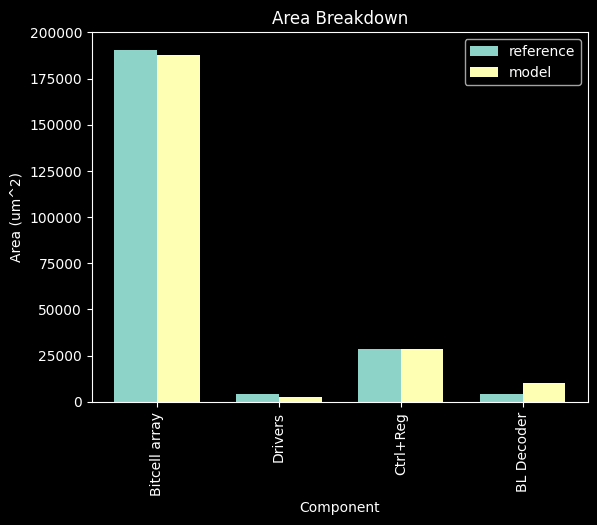

In [2]:
result = run_test("colonnade_jssc_2021", "test_area_breakdown")
bar_side_by_side(
    result[0].get_compare_ref_area(),
    xlabel="Component",
    ylabel="Area (um^2)",
    title="Area Breakdown",
)


   ### Energy Breakdown

   This test replicates the results presented in Fig. 17 of the paper. Energy
   is measured using 8b weights.

   We show the energy breakdown fo the macro. The energy is broken down into
   the following components:

   - Bitcell Array: The energy consumed by the SRAM cells and digital CiM
     circuitry (1b multiply, adders, configuration) in the array.
   - Drivers: The energy consumed by the array drivers. Note that we model a
     transposed version of the macro, so our drivers are modeled as wordline
     drivers while the Colonnade paper uses bitline drivers.
   - Ctrl+Reg: The energy consumed by the control logic and registers.
     Registers include those inside the array that accomplish in-array
     pipelining.
   - BL Decoder: Note that in Colonnade this is actually a WL decoder, but
     we're transposed in this model.

   We can see that the bitcell array consumes the majority of the macro's
   energy. This is because the digital CiM macro requires a full adder and
   configuration circuits to be connected to every SRAM bitcell, resulting in
   high area and energy overhead for the SRAM array.

   

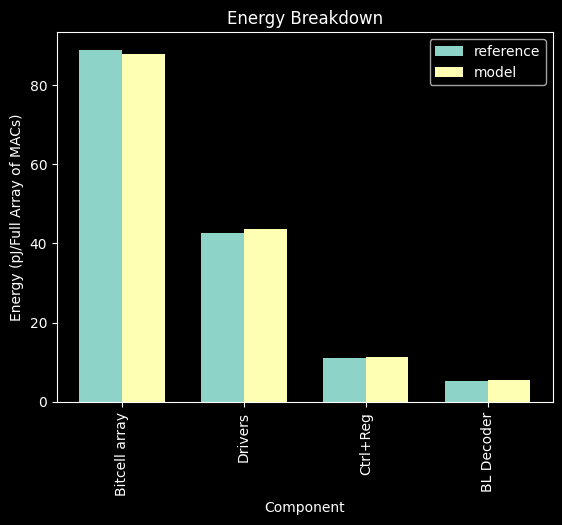

In [3]:
result = run_test("colonnade_jssc_2021", "test_energy_breakdown")
bar_side_by_side(
    result[0].get_compare_ref_energy(),
    xlabel="Component",
    ylabel="Energy (pJ/Full Array of MACs)",
    title="Energy Breakdown",
)


   ### Energy vs. Number of Weight Bits

   This test replicates the results presented in Fig. 16b of the paper. The
   macro supports between 1 and 16 weight bits. For three different voltages,
   the energy per MAC of the macro is measured for varying numbers of weight
   bits. We fix the number of input bits to 1. We also fix the clock frequency
   at 100MHz, as is done in the paper (for measurement purposes; the macro can
   support higher frequencies).

   We see that the number of weight bits scales energy because of two factors.

   - First, as the number of weight bits increases, the number of adders
     required to compute MAC results increases, leading to higher energy
     consumption. The number of full adders required to compute each MAC is
     equal to the number of weight bits plus 7. This is because the weights are
     stored in the array and the accumulation results of up to 128 MACs are
     propagated through adders. The array therefore requires one adder for
     each weight bit plus an additional 7 adders per weight to store the
     full precision of the accumulation results.
   - Second, as the number of weight bits increases, the number of parallel
     MACs that the array can perform decreases. This will lead to a decrease in
     the number of parallel MACs, and thus an increase in energy per MAC. This
     effect leads to steps in the energy each time the number of parallel MACs
     decreases. For example, there is a step when going from 14b (21 columns
     per weight, 6 parallel MACs per row) to 15b weights (22 columns per
     weight, 5 parallel MACs per row).

   We also see that the energy per MAC increases with voltage.

   There are two significant differences between published and modeled results:

   - In the published results, the energy per MAC does not increase
     monotonically with the number of weight bits. Energy per MAC may decrease
     from N to N+1 bit weights if the number of parallel MACs is the same for
     both N and N+1 bit weights (i.e., the array utilization is the same for
     both). We attribute this to a change in data-value-dependent switching
     activity of adders in the array, and this effect could be captured with a
     more complex data-value-dependent calculation.
   - In the published results, the energy per MAC decreases rapidly as supply
     voltage decreases (~1.6x from 0.8V to 0.7V and ~4x from 0.8V to 0.6V).
     This is likely due to some technology-specific effects. We could model it
     by using a piecewise function for VOLTAGE_ENERGY_SCALE and passing it to
     all subcomponent models, but we instead chose to use simple V^2 scaling.

   

100%|██████████| 48/48 [00:09<00:00,  5.27it/s]


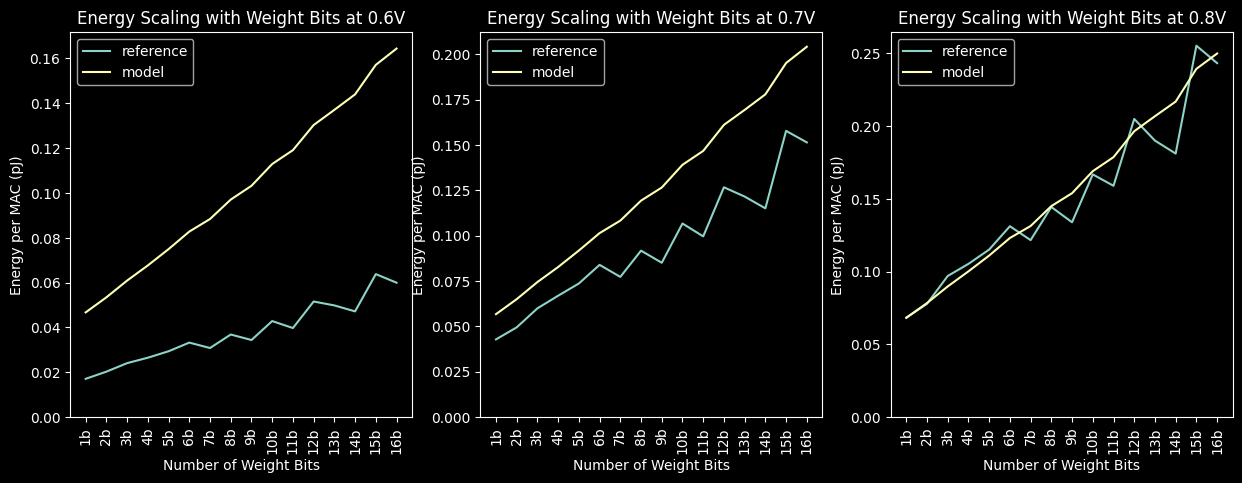

In [4]:
result = run_test("colonnade_jssc_2021", "test_energy_weight_bits_scaling")
voltages = result.split_by("VOLTAGE")
fig, axs = plt.subplots(1, len(voltages), figsize=(5 * len(voltages), 5))
for i, result_voltage in enumerate(voltages):
    plot(
        {
            f"{r.variables['WEIGHT_BITS']}b": r.per_mac("total_energy")
            for r in result_voltage
        },
        ax=axs[i],
        xlabel="Number of Weight Bits",
        ylabel="Energy per MAC (pJ)",
        title=f"Energy Scaling with Weight Bits at {result_voltage[0].variables['VOLTAGE']}V",
    )

In [5]:
bar_stacked(
    {f"{r.variables['WEIGHT_BITS']}b": r.per_mac("energy") for r in result_voltage},
    ax=axs[i],
    xlabel="Number of Weight Bits",
    ylabel="Energy per MAC (pJ)",
    title=f"Energy Scaling with Weight Bits at {result_voltage[0].variables['VOLTAGE']}V",
)


   # Energy vs. Number of Input and Weight Bits

   This test replicates the results presented in Fig. 16a of the paper. Like
   with the energy versus weight bits test, we'll test three voltages and
   measure energy 1-16b weights. This time, we vary the number of input bits as
   well, using the same number of input bits as weight bits.

   We can see that, in addition to the energy increasing with the number of
   weight bits, the energy also increases linearly with the number of input
   bits because an N-bit input is processed in N cycles and N activations of
   the array.  We also fix the clock frequency at 100MHz, as is done in the
   paper (for measurement purposes; the macro can support higher frequencies).

   Modeled and reference results vary for the same two reasons as the energy
   versus weight bits test, and could be made closer by using a more complex
   data-value-dependent calculation for the energy of the adders in the array,
   and by using a more complex voltage-energy scaling function.
   

100%|██████████| 48/48 [00:09<00:00,  5.33it/s]


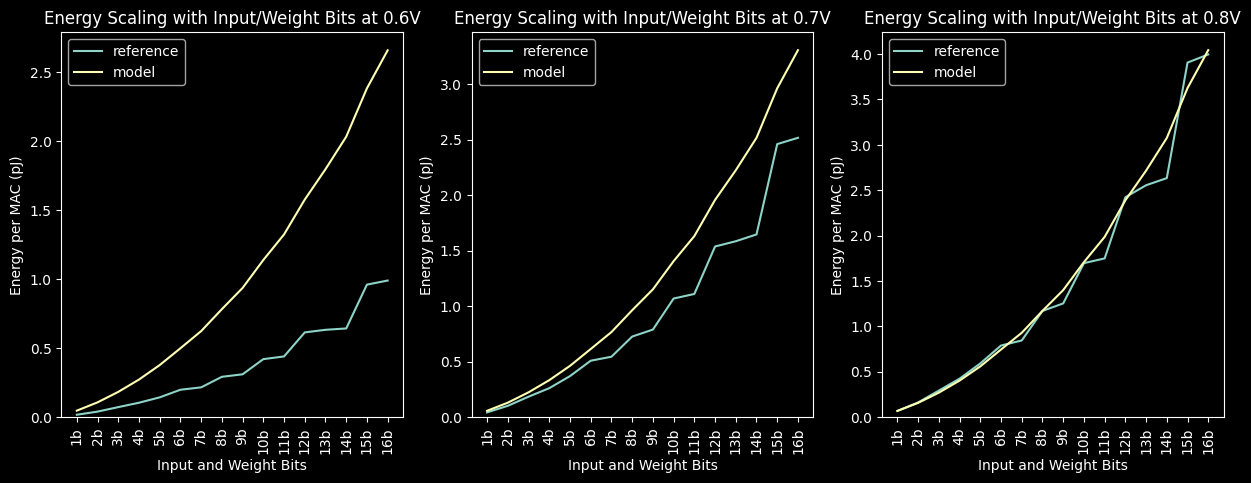

In [6]:
result = run_test("colonnade_jssc_2021", "test_energy_input_weight_bits_scaling")
voltages = result.split_by("VOLTAGE")

fig, axs = plt.subplots(1, len(voltages), figsize=(5 * len(voltages), 5))
for i, result_voltage in enumerate(voltages):
    plot(
        {
            f"{r.variables['WEIGHT_BITS']}b": r.per_mac("total_energy")
            for r in result_voltage
        },
        ax=axs[i],
        xlabel="Input and Weight Bits",
        ylabel="Energy per MAC (pJ)",
        title=f"Energy Scaling with Input/Weight Bits at {result_voltage[0].variables['VOLTAGE']}V",
    )


   ### Throughput vs. Number of Registers per Column

   This test replicates the results presented in Fig. 15a of the paper. The
   number of registers in the macro is varied from 1 to 16. A register in the
   macro is a flip flop, one for each column in the array, that breaks up the
   critical path length into a smaller number of rows to allow for higher clock
   frequencies.

   In addition to varying the number of registers, the number of input and
   weight bits are varied from 1 to 16.

   Throughput increases with the number of registers as the critical path
   latency reduces. Effects begin to saturate with many registers as the
   critical path begins to become dominated by the full adders communicating
   between columns rather than between rows (i.e., carry signals propagating
   between adders in the same row, rather than sum signals propagating between
   adders in the same column).

   We also find that throughput decreases approximately quadratically as we
   increase the number of input and weight bits because the number of clock
   cycles increases linearly with the number of input bits and the number of
   computations computed by the array decreases approximately linearly with the
   number of weight bits.

   

100%|██████████| 80/80 [00:13<00:00,  5.88it/s]


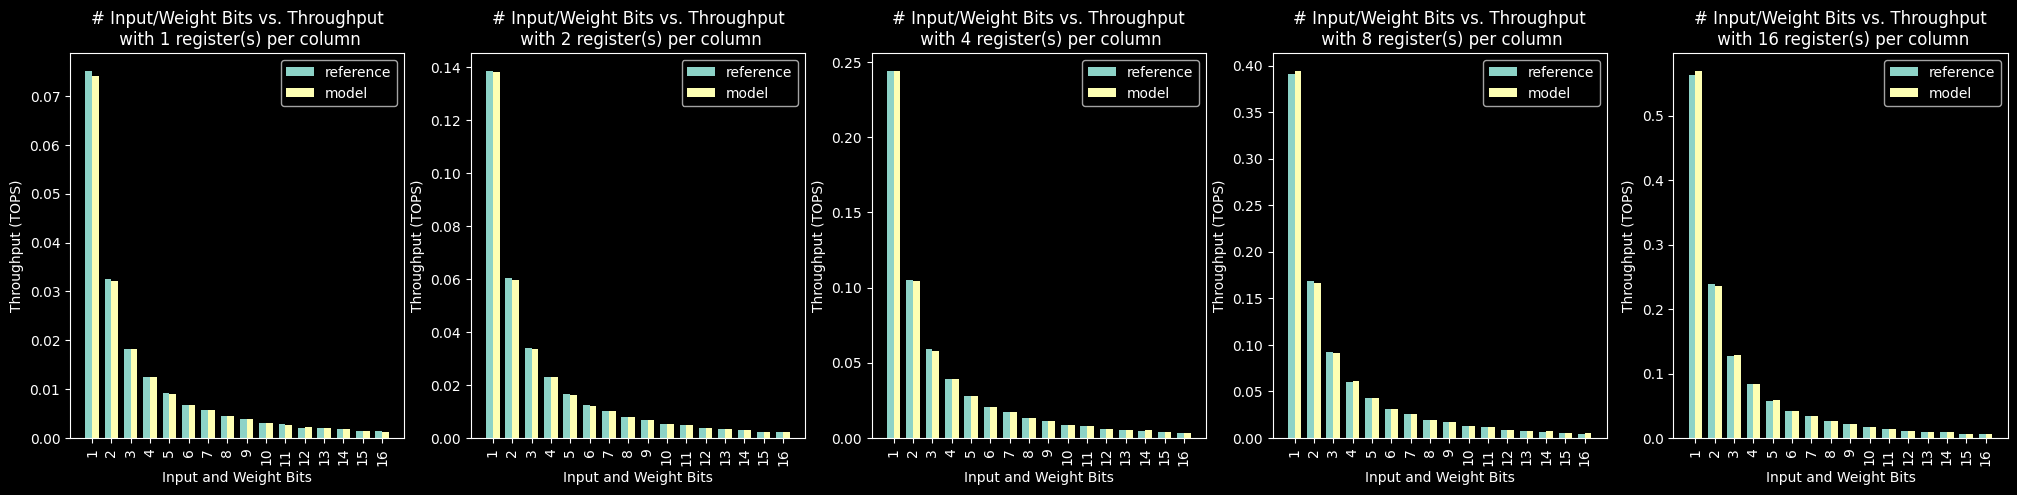

In [7]:
result = run_test("colonnade_jssc_2021", "test_throughput_scaling")
n_reg_cols = result.split_by("N_REGS_PER_COL")
fig, axs = plt.subplots(1, len(n_reg_cols), figsize=(5 * len(n_reg_cols), 5))
for i, result_n_reg_col in enumerate(n_reg_cols):
    rc = f"{result_n_reg_col[0].variables['N_REGS_PER_COL']}"
    bar_side_by_side(
        {r.variables["WEIGHT_BITS"]: r.tops for r in result_n_reg_col},
        ax=axs[i],
        xlabel="Input and Weight Bits",
        ylabel="Throughput (TOPS)",
        title=f"# Input/Weight Bits vs. Throughput\n with {rc} register(s) per column",
    )


   ### Latency vs. Number of Registers per Column

   This test replicates the results presented in Fig. 16b of the paper. Like in
   the previous test, the number of registers in the macro is varied from 1 to
   16. The latency of the macro is measured for varying numbers of registers.

   Note that in other tests, the macro is bit pipelined, meaning that when one
   pipeline stage (a stage being a row group in the array) finishes processing
   a bit, it is immediately filled with the next bit even if all pipeline stages
   are not finished processing the current bit. In this test, the macro is NOT
   bit pipelined, meaning that all pipeline stages need to be flushed before
   processing the next bit. This significantly increases the latency of the
   macro.

   We find first that latency increases approximately linearly with the number
   of input bits because each additional input bit requires an additional clock
   cycle to process. We find that, at first, latency decreases with additional
   registers because the critical path length of the array is reduced. However,
   at a certain point (2-4 registers depending on the number of input bits),
   latency begins to increase because flushing the pipeline requires additional
   clock cycles.
   

100%|██████████| 80/80 [00:13<00:00,  5.89it/s]


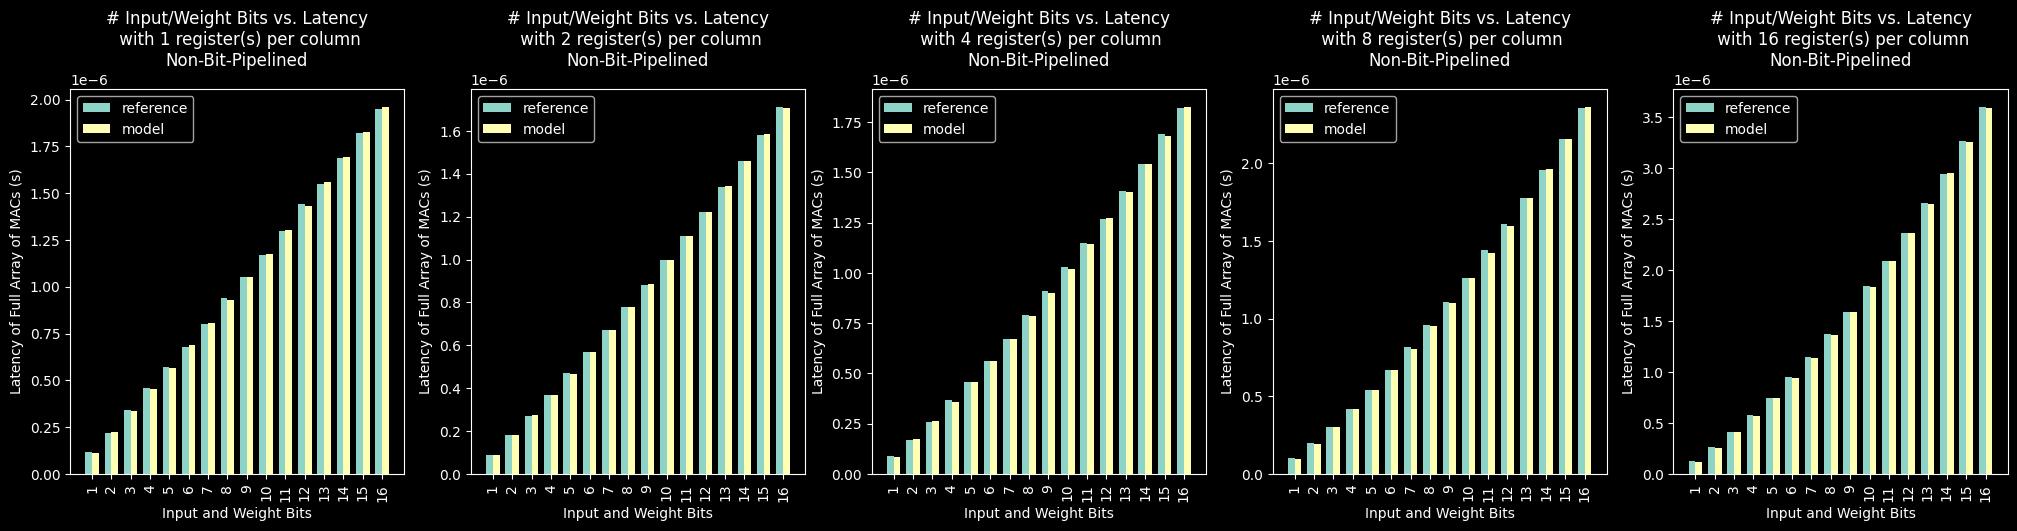

In [8]:
result = run_test("colonnade_jssc_2021", "test_latency_scaling")
n_reg_cols = result.split_by("N_REGS_PER_COL")
fig, axs = plt.subplots(1, len(n_reg_cols), figsize=(5 * len(n_reg_cols), 5))
for i, result_n_reg_col in enumerate(n_reg_cols):
    rc = f"{result_n_reg_col[0].variables['N_REGS_PER_COL']}"
    bar_side_by_side(
        {r.variables["WEIGHT_BITS"]: r.latency for r in result_n_reg_col},
        ax=axs[i],
        xlabel="Input and Weight Bits",
        ylabel="Latency of Full Array of MACs (s)",
        title=f"# Input/Weight Bits vs. Latency\n with {rc} register(s) per column\nNon-Bit-Pipelined",
    )